#### Адонин Антон 22931

# Simpsons Classification
#### В данной лабораторной работе представлено обучение нейронной сети ResNet50 для распознавания героев мультсериала "Симпсоны".
##### Сама работа состоит из 2 этапов:
##### 1. Работа с данными.
    a. Удаление дубликатов.
    b. Обогащение тренировочных данных. Аугментация классов с малой репрезентативностью.

##### 2. Работа с моделью.
    a. Подсчет среднего и стандартного отклонения тренировочной выборки. (Для нормализации).
    b. Разбиение тренировочных данных на выборки: тренировочная, валидационная.
    c. Создание лоадеров и инициализация модели.
    d. Обучение модели.
    e. Тестирование модели. Подсчет метрик.

### Работа с данными

#### Импортируем необходимые модули

In [1]:
import hashlib
import math
import os
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

# 1. Работа с данными.

Прописываем относительный путь до директорий с данными

In [2]:
train_dir = Path('./train_dir/simpsons_dataset/')
test_dir = Path('./test_dir/kaggle_simpson_testset/')


def list_of_files(directory: str, with_aug=True):
    """
    Returns a list of files in a directory.
    :param directory: 
    :param with_aug: True by default. Returns augmented files which exist in directory if True.
    :return: list of file paths
    """
    filename = '*/*.jpg'
    if with_aug:
        filename = '*/*.*'
    files_training = glob(os.path.join(directory, filename))
    print('Number of images in Training dir:', len(files_training))
    return files_training


# list_of_files(train_dir)

Number of images in Training dir: 31015


['train_dir\\simpsons_dataset\\abraham_grampa_simpson\\pic_0000.jpg',
 'train_dir\\simpsons_dataset\\abraham_grampa_simpson\\pic_0001.jpg',
 'train_dir\\simpsons_dataset\\abraham_grampa_simpson\\pic_0002.jpg',
 'train_dir\\simpsons_dataset\\abraham_grampa_simpson\\pic_0003.jpg',
 'train_dir\\simpsons_dataset\\abraham_grampa_simpson\\pic_0004.jpg',
 'train_dir\\simpsons_dataset\\abraham_grampa_simpson\\pic_0005.jpg',
 'train_dir\\simpsons_dataset\\abraham_grampa_simpson\\pic_0006.jpg',
 'train_dir\\simpsons_dataset\\abraham_grampa_simpson\\pic_0007.jpg',
 'train_dir\\simpsons_dataset\\abraham_grampa_simpson\\pic_0008.jpg',
 'train_dir\\simpsons_dataset\\abraham_grampa_simpson\\pic_0009.jpg',
 'train_dir\\simpsons_dataset\\abraham_grampa_simpson\\pic_0010.jpg',
 'train_dir\\simpsons_dataset\\abraham_grampa_simpson\\pic_0011.jpg',
 'train_dir\\simpsons_dataset\\abraham_grampa_simpson\\pic_0012.jpg',
 'train_dir\\simpsons_dataset\\abraham_grampa_simpson\\pic_0013.jpg',
 'train_dir\\simpson

In [3]:
# Имена классов
CLASS_NAMES = []
for i in os.listdir(train_dir):
    if not i.startswith('.'):
        CLASS_NAMES.append(i)

In [4]:
def generate_md5_hash(file_path):
    """
    Returns md5 hash of file by its path.
    :param file_path: Path of file.
    :return: str, md5 hash of file
    """
    with open(file_path, 'rb') as file:
        # Read the file contents
        data = file.read()

        # Calculate the MD5 hash
        md5_hash = hashlib.md5(data).hexdigest()

        return md5_hash

In [5]:
def remove_duplicates_from_dir(directory) -> None:
    """
    Removes duplicates from directory.
    :param directory: 
    :return: None
    """
    hashes = {}
    file_paths = glob(os.path.join(directory, '*.jpg'))
    for path in file_paths:
        hash_image = generate_md5_hash(path)
        if hash_image not in hashes:
            hashes[hash_image] = []
        hashes[hash_image].append(path)
    duplicate_counter = 0
    for hash, images in hashes.items():
        if len(images) > 1:
            for image in images[1:]:
                os.remove(image)
                duplicate_counter += 1
    if duplicate_counter > 0:
        print(f"removed {duplicate_counter} duplicate from {dir}")

Удаляем дубликаты

In [6]:
# Удаление дубликатов из папок
for dir in glob(os.path.join(train_dir, "*")):
    remove_duplicates_from_dir(dir)
for dir in glob(os.path.join(test_dir, "*")):
    remove_duplicates_from_dir(dir)

In [7]:
def items_per_class(directory):
    """
    Returns the number of items in class.
    :param directory: parent directory of classes 
    :return: dict, {class : number_of_items}
    """
    class_quantity = {i: 0 for i in CLASS_NAMES}
    for class_name in CLASS_NAMES:
        if not class_name.startswith('.'):
            class_path = os.path.join(directory, class_name)
            num_images = len(glob(os.path.join(class_path, '*.*')))
            class_quantity[class_name] += num_images
    return class_quantity

Total classes: 42
Items per class:
abraham_grampa_simpson 913
agnes_skinner 504
apu_nahasapeemapetilon 623
barney_gumble 502
bart_simpson 1342
carl_carlson 503
charles_montgomery_burns 1193
chief_wiggum 986
cletus_spuckler 506
comic_book_guy 501
disco_stu 512
edna_krabappel 501
fat_tony 504
gil 504
groundskeeper_willie 501
homer_simpson 2246
kent_brockman 501
krusty_the_clown 1206
lenny_leonard 501
lionel_hutz 192
lisa_simpson 1354
maggie_simpson 503
marge_simpson 1291
martin_prince 505
mayor_quimby 501
milhouse_van_houten 1079
miss_hoover 502
moe_szyslak 1452
ned_flanders 1454
nelson_muntz 501
otto_mann 512
patty_bouvier 504
principal_skinner 1194
professor_john_frink 505
rainier_wolfcastle 506
ralph_wiggum 504
selma_bouvier 503
sideshow_bob 877
sideshow_mel 508
snake_jailbird 505
troy_mcclure 512
waylon_smithers 502


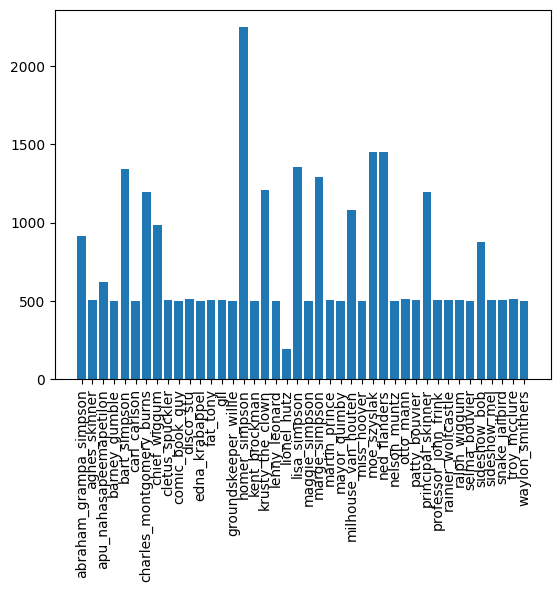

In [8]:
def print_classes_plot(directory):
    """
    Shows plot of the number of items in classes.
    :param directory: parent directory of classes.
    :return: None
    """
    class_stat = items_per_class(directory)
    plt.bar(class_stat.keys(), class_stat.values(), align='center')
    plt.xticks(rotation=90)
    print(f"Total classes: {len(class_stat.keys())}")
    print(f"Items per class:")
    for key, value in class_stat.items():
        print(key, value)
    plt.show()


print_classes_plot(train_dir)

In [9]:
def get_low_quality_classes(left, right):
    """
    Returns a list of classes which are left <= N <= right. Where N = number of items. 
    :param left: int
    :param right: int
    :return: list of classes
    """
    low_quantity_classes = []
    class_stat = items_per_class(train_dir)
    for key, value in class_stat.items():
        if left <= value <= right:
            low_quantity_classes.append(key)
            print(key, value)

    print(f"Classes with items [{left}:{right}] : {len(low_quantity_classes)}")
    print(low_quantity_classes)
    return low_quantity_classes

In [10]:
def remove_augmentations():
    """
    Removes "basic" augmentations from train dir
    :return: None
    """
    files_augmented = glob(os.path.join(train_dir, '*/aug*.png'))
    for file in files_augmented:
        os.remove(file)
    print("All augmentations removed: ", len(files_augmented))


def remove_random_augmentations():
    """
    Removes "random" augmentations from train dir
    :return: None
    """
    files_augmented = glob(os.path.join(train_dir, '*/random*.png'))
    for file in files_augmented:
        os.remove(file)
    print("All augmentations removed: ", len(files_augmented))

# remove_augmentations()
# remove_random_augmentations()

In [11]:


def apply_basic_aug():
    """
    Применение "базовой" аугментации к классу.
    (1) размытие по гауссу с ядром (25, 25)
    (2) Горизонтальный флип.
    
    Функция делает из 3 фото 12 штук. Нужна чтобы раздуть классы с очень маленькой численностью.
    (1) 3 базовых => 3 базовых + 3 размытых
    (2) 3 базовых 3 размытых => 3 базовых 3 размытых + 3 флипнутые базовые 3 флипнутые размытые 
    """
    blur_transform = transforms.GaussianBlur(kernel_size=(25, 25), sigma=(0.2, 4.0))
    flip_transform = transforms.RandomHorizontalFlip(p=1)

    classes = get_low_quality_classes(0, 30)

    for class_name in tqdm(classes):
        dir_path = os.path.join(train_dir, class_name)
        pictures = glob(os.path.join(dir_path, '*'))
        pic_number = len(pictures)
        for filename in pictures:
            image = Image.open(filename)
            path = os.path.join(dir_path, f"aug_pic{pic_number}.png")
            blurred = blur_transform(image)
            blurred.save(path)
            pic_number += 1
    print(f"blurred")

    for class_name in tqdm(classes):
        dir_path = os.path.join(train_dir, class_name)
        pictures = glob(os.path.join(dir_path, '*'))
        pic_number = len(pictures)
        for filename in pictures:
            image = Image.open(filename)
            path = os.path.join(dir_path, f"aug_pic{pic_number}.png")
            flipped = flip_transform(image)
            flipped.save(path)
            pic_number += 1
    print(f"flipped")


apply_basic_aug()

Classes with items [0:30] : 0
[]


0it [00:00, ?it/s]


blurred


0it [00:00, ?it/s]

flipped


In [12]:
# Применяем автоматическую аугментацию
classes = get_low_quality_classes(0, 500)
if len(classes) == 1:
    classes = []
for class_name in classes:
    dir_path = os.path.join(train_dir, class_name)
    pictures = glob(os.path.join(dir_path, '*'))
    pic_number = len(pictures)
    aug_per_pic = math.ceil((500 - pic_number) / pic_number)
    random_augment_transform = transforms.Compose([transforms.PILToTensor(),
                                                   transforms.RandAugment(num_ops=aug_per_pic + 2),
                                                   transforms.ToPILImage()])
    # Максимально возможное количество операций аугментации для каждого класса - 15 на каждую картинку
    if aug_per_pic > 15:
        aug_per_pic = 15
    rand = transforms.RandAugment(num_ops=aug_per_pic + 2)
    for filename in tqdm(pictures):
        image = Image.open(filename)
        for i in range(aug_per_pic):
            path = os.path.join(dir_path, f"random_aug_pic{pic_number}.png")
            augmented = rand(image)
            augmented.save(path)
            pic_number += 1
        if pic_number > 500:
            break

lionel_hutz 192
Classes with items [0:500] : 1
['lionel_hutz']


Total classes: 42
Items per class:
abraham_grampa_simpson 913
agnes_skinner 504
apu_nahasapeemapetilon 623
barney_gumble 502
bart_simpson 1342
carl_carlson 503
charles_montgomery_burns 1193
chief_wiggum 986
cletus_spuckler 506
comic_book_guy 501
disco_stu 512
edna_krabappel 501
fat_tony 504
gil 504
groundskeeper_willie 501
homer_simpson 2246
kent_brockman 501
krusty_the_clown 1206
lenny_leonard 501
lionel_hutz 192
lisa_simpson 1354
maggie_simpson 503
marge_simpson 1291
martin_prince 505
mayor_quimby 501
milhouse_van_houten 1079
miss_hoover 502
moe_szyslak 1452
ned_flanders 1454
nelson_muntz 501
otto_mann 512
patty_bouvier 504
principal_skinner 1194
professor_john_frink 505
rainier_wolfcastle 506
ralph_wiggum 504
selma_bouvier 503
sideshow_bob 877
sideshow_mel 508
snake_jailbird 505
troy_mcclure 512
waylon_smithers 502


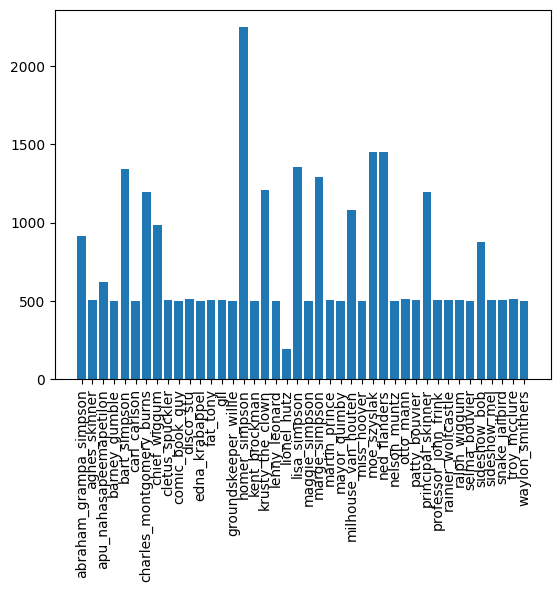

In [13]:
print_classes_plot(train_dir)

# 2. Работа с моделью.

#### Импортируем необходимые библиотеки

In [14]:
import numpy as np
import torch
import torchvision
import torchvision.datasets as datasets

In [15]:
num_epochs = 300
learning_rate = 0.001
batch_size = 8
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

In [16]:
images_dataset = datasets.ImageFolder(root=train_dir, transform=transforms.Compose([transforms.Resize((256, 256)),
                                                                                    transforms.CenterCrop(224), transforms.ToTensor()]))
images_dataset.idx_to_class = {v: k for k, v in images_dataset.class_to_idx.items()}

In [17]:
from torch.utils.data import SubsetRandomSampler
from sklearn.model_selection import train_test_split


def get_loaders(dataset, train_size=0.9):
    """
    Splits train dataset to train and validation samples.
    Returns loaders.
    :param dataset: 
    :param train_size: The size of the training sample relative to the source data
    :return: (train_loader, validation_loader) - tuple
    """
    length = len(dataset)
    indices = list(range(length))
    train_ind, val_ind = train_test_split(indices, train_size=train_size, stratify=dataset.targets, shuffle=True, random_state=42)
    train_sampler = SubsetRandomSampler(train_ind)
    valid_sampler = SubsetRandomSampler(val_ind)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                               sampler=train_sampler)
    validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=valid_sampler)
    return train_loader, validation_loader


In [18]:
train_loader, validation_loader = get_loaders(images_dataset)

#### Подсчет среднего и стандартного отклонения тренировочной выборки.

In [19]:
def calculate_mean_std(loader):
    """
    Calculate the mean and std of the images
    :param indices: train indices of dataset images
    :return: (mean, std) - tuple
    """
    print('==> Computing mean and std..')

    total_sum = torch.tensor([0.0, 0.0, 0.0])
    total_sum_square = torch.tensor([0.0, 0.0, 0.0])

    for inputs, labels in tqdm(loader):
        total_sum += inputs.sum(axis=[0, 2, 3])
        total_sum_square += (inputs ** 2).sum(axis=[0, 2, 3])

    # len(df) = Number of images in dataset (df)
    image_size = 224
    count = len(loader) * loader.batch_size * image_size * image_size

    # mean and std
    total_mean = total_sum / count
    total_var = (total_sum_square / count) - (total_mean ** 2)
    total_std = torch.sqrt(total_var)
    # output
    print(f'mean: {total_mean}')
    print(f'std:  {total_std}')
    return total_mean, total_std

In [20]:
# dataset_mean, dataset_std = calculate_mean_std(train_loader)
dataset_mean = torch.tensor([0.4492, 0.4071, 0.3481])
dataset_std = torch.tensor([0.2709, 0.2514, 0.2729])

In [21]:
# Добавляем нормализацию к трансформации датасета
dataset_transform = transforms.Compose([transforms.Resize((256, 256)),
                                        transforms.CenterCrop(224), transforms.ToTensor(),
                                        transforms.Normalize(mean=dataset_mean, std=dataset_std)])
images_dataset.transform = dataset_transform
images_dataset.transform

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=tensor([0.4492, 0.4071, 0.3481]), std=tensor([0.2709, 0.2514, 0.2729]))
)

#### Инициализируем модель

In [22]:
model = torchvision.models.resnet50(weights=None)
model_filename = "sgd_model.pth"
if model_filename in os.listdir():
    model.load_state_dict(torch.load(model_filename, map_location=torch.device(device)))

# Set the model to run on the device
model = model.to(device)

In [23]:
# минимальная потеря на валидации
min_valid_loss = np.inf

# Определяем функцию потери
criterion = torch.nn.CrossEntropyLoss()

# Определяем оптимайзер
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

#### Обучение модели

In [24]:
def train():
    global min_valid_loss
    # Train the model...
    for epoch in range(num_epochs):
        print(f"Running {epoch + 1} epoch")
        train_loss = 0.0
        model.train()
        for inputs, labels in tqdm(train_loader, mininterval=1):
            # Move input and label tensors to the device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Zero out the optimizer
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            train_loss = loss.item() * inputs.size(0)

            # Backward pass
            loss.backward()
            optimizer.step()

        valid_loss = 0.0
        model.eval()
        for inputs, labels in tqdm(validation_loader, mininterval=1):
            inputs = inputs.to(device)
            labels = labels.to(device)

            target = model(inputs)
            loss = criterion(target, labels)
            valid_loss = loss.item() * inputs.size(0)
        # Печатаем ошибку для каждой эпохи
        print(
            f'Epoch {epoch + 1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(validation_loader)}')
        if min_valid_loss > valid_loss:
            print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
            min_valid_loss = valid_loss
            torch.save(model.state_dict(), model_filename)

    print(f'Finished Training, Loss: {loss.item():.4f}')

In [25]:
# train()

Running 1 epoch


100%|██████████| 388/388 [00:33<00:00, 11.57it/s]


Epoch 1 		 Training Loss: 0.0011712437714410033 		 Validation Loss: 0.0236945053965775
Validation Loss Decreased(inf--->9.193468) 	 Saving The Model
Running 2 epoch


100%|██████████| 388/388 [00:33<00:00, 11.59it/s]


Epoch 2 		 Training Loss: 0.0015707714168253465 		 Validation Loss: 0.022523397637396744
Validation Loss Decreased(9.193468--->8.739078) 	 Saving The Model
Running 3 epoch


100%|██████████| 388/388 [00:31<00:00, 12.22it/s]


Epoch 3 		 Training Loss: 0.0008778122571272973 		 Validation Loss: 0.028458047773420196
Running 4 epoch


100%|██████████| 388/388 [00:36<00:00, 10.63it/s]


Epoch 4 		 Training Loss: 0.0003239116559397525 		 Validation Loss: 0.006049808614032785
Validation Loss Decreased(8.739078--->2.347326) 	 Saving The Model
Running 5 epoch


100%|██████████| 388/388 [00:31<00:00, 12.16it/s]


Epoch 5 		 Training Loss: 0.0014773950877367255 		 Validation Loss: 0.0014476132070280843
Validation Loss Decreased(2.347326--->0.561674) 	 Saving The Model
Running 6 epoch


100%|██████████| 388/388 [00:31<00:00, 12.32it/s]


Epoch 6 		 Training Loss: 0.001069172200637424 		 Validation Loss: 0.007413911450769484
Running 7 epoch


100%|██████████| 388/388 [00:34<00:00, 11.15it/s]


Epoch 7 		 Training Loss: 0.0005217968563637282 		 Validation Loss: 0.020582068212253533
Running 8 epoch


100%|██████████| 388/388 [00:35<00:00, 10.90it/s]


Epoch 8 		 Training Loss: 0.0011263082225548163 		 Validation Loss: 0.009463927487737125
Running 9 epoch


100%|██████████| 388/388 [00:33<00:00, 11.61it/s]


Epoch 9 		 Training Loss: 0.0017525634656321354 		 Validation Loss: 0.024154451704516855
Running 10 epoch


  1%|          | 21/3490 [00:03<08:38,  6.69it/s]


KeyboardInterrupt: 

#### Прогон модели на тестовых данных

Total classes: 42
Items per class:
abraham_grampa_simpson 46
agnes_skinner 0
apu_nahasapeemapetilon 50
barney_gumble 0
bart_simpson 47
carl_carlson 0
charles_montgomery_burns 47
chief_wiggum 49
cletus_spuckler 0
comic_book_guy 49
disco_stu 0
edna_krabappel 46
fat_tony 0
gil 0
groundskeeper_willie 0
homer_simpson 47
kent_brockman 47
krusty_the_clown 48
lenny_leonard 42
lionel_hutz 0
lisa_simpson 50
maggie_simpson 0
marge_simpson 50
martin_prince 0
mayor_quimby 47
milhouse_van_houten 47
miss_hoover 0
moe_szyslak 49
ned_flanders 49
nelson_muntz 48
otto_mann 0
patty_bouvier 0
principal_skinner 50
professor_john_frink 0
rainier_wolfcastle 0
ralph_wiggum 0
selma_bouvier 0
sideshow_bob 47
sideshow_mel 0
snake_jailbird 0
troy_mcclure 0
waylon_smithers 0


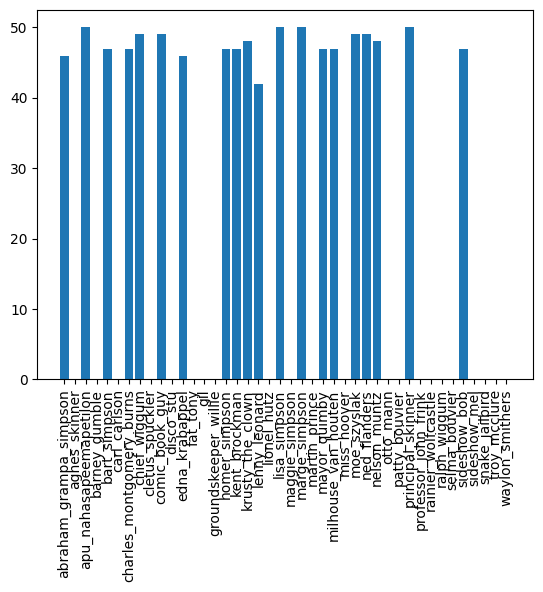

In [24]:
print_classes_plot(test_dir)

In [25]:
test_dataset = datasets.ImageFolder(
    root=test_dir, transform=dataset_transform
)
test_dataset.idx_to_class = {v: k for k, v in test_dataset.class_to_idx.items()}
test_dataset.idx_to_class

{0: 'abraham_grampa_simpson',
 1: 'apu_nahasapeemapetilon',
 2: 'bart_simpson',
 3: 'charles_montgomery_burns',
 4: 'chief_wiggum',
 5: 'comic_book_guy',
 6: 'edna_krabappel',
 7: 'homer_simpson',
 8: 'kent_brockman',
 9: 'krusty_the_clown',
 10: 'lenny_leonard',
 11: 'lisa_simpson',
 12: 'marge_simpson',
 13: 'mayor_quimby',
 14: 'milhouse_van_houten',
 15: 'moe_szyslak',
 16: 'ned_flanders',
 17: 'nelson_muntz',
 18: 'principal_skinner',
 19: 'sideshow_bob'}

In [26]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=True)

In [30]:
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        class_names = [test_dataset.idx_to_class[int(idx)] for idx in labels]
        # y_true.extend([images_dataset.class_to_idx[name] for name in class_names])
        y_true.extend(class_names)
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        outputs = outputs
        _, predicted = torch.max(outputs, 1)
        # y_pred.extend(predicted.cpu().numpy())
        y_pred.extend([images_dataset.idx_to_class[idx] for idx in predicted.cpu().numpy()])


100%|██████████| 120/120 [00:07<00:00, 15.63it/s]


In [32]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_true, y_pred, labels=test_dataset.classes)

C:\Users\79137\AppData\Local\Temp\ipykernel_14628\3451426370.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(test_dataset.classes)
C:\Users\79137\AppData\Local\Temp\ipykernel_14628\3451426370.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(test_dataset.classes)


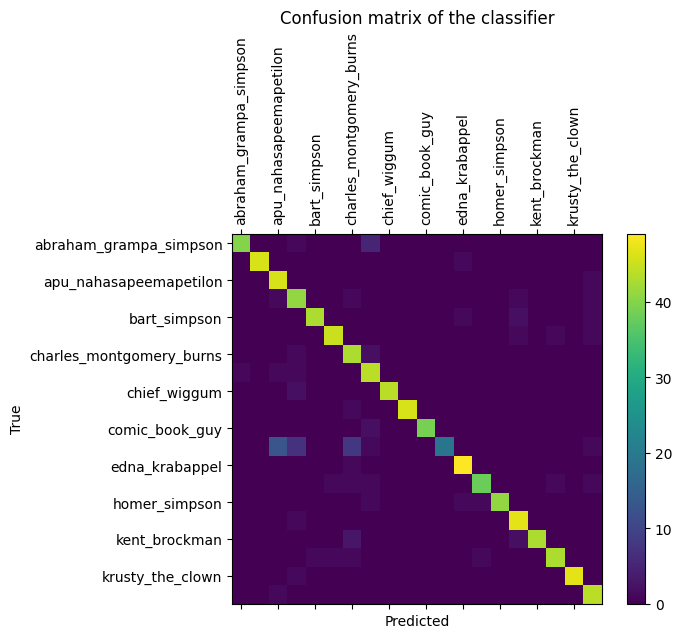

In [33]:
from matplotlib.ticker import MaxNLocator

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cf_matrix)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels(test_dataset.classes)
ax.set_yticklabels(test_dataset.classes)
ax.yaxis.set_major_locator(MaxNLocator(prune='both'))
ax.xaxis.set_major_locator(MaxNLocator(prune='both'))
plt.xticks(rotation=90)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [34]:
from sklearn.metrics import multilabel_confusion_matrix

multi_cf = multilabel_confusion_matrix(y_true=y_true, y_pred=y_pred, labels=images_dataset.classes)

![title](https://pythonru.com/wp-content/uploads/2021/03/matrica-oshibok-dlya-binarnoj-klassifikacii-1024x576.png)


In [34]:

for class_name in images_dataset.classes:
    idx = images_dataset.class_to_idx[class_name]
    class_cf = np.flip(multi_cf[idx])
    if class_name not in test_dataset.classes:
        continue
    tp = class_cf[0][0]
    fn = class_cf[0][1]
    fp = class_cf[1][0]
    tn = class_cf[1][1]
    total = class_cf.sum()
    accuracy = (tp + tn) / total
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    print(class_name)
    print(f"accuracy: {round(accuracy, 4)} \t\t precision: {round(precision, 4)} \t\t recall: {round(recall, 4)} \t\t f1: {round(f1, 4)}\n")

abraham_grampa_simpson
accuracy: 0.9885 		 precision: 0.8182 		 recall: 0.9783 		 f1: 0.8911

apu_nahasapeemapetilon
accuracy: 0.9969 		 precision: 1.0 		 recall: 0.94 		 f1: 0.9691

bart_simpson
accuracy: 0.9958 		 precision: 0.9388 		 recall: 0.9787 		 f1: 0.9583

charles_montgomery_burns
accuracy: 0.9864 		 precision: 1.0 		 recall: 0.7234 		 f1: 0.8395

chief_wiggum
accuracy: 0.9969 		 precision: 1.0 		 recall: 0.9388 		 f1: 0.9684

comic_book_guy
accuracy: 0.9969 		 precision: 1.0 		 recall: 0.9388 		 f1: 0.9684

edna_krabappel
accuracy: 0.9969 		 precision: 0.9574 		 recall: 0.9783 		 f1: 0.9677

homer_simpson
accuracy: 0.9895 		 precision: 1.0 		 recall: 0.7872 		 f1: 0.881

kent_brockman
accuracy: 0.9937 		 precision: 0.9556 		 recall: 0.9149 		 f1: 0.9348

krusty_the_clown
accuracy: 0.9801 		 precision: 0.7164 		 recall: 1.0 		 f1: 0.8348

lenny_leonard
accuracy: 0.999 		 precision: 0.9767 		 recall: 1.0 		 f1: 0.9882

lisa_simpson
accuracy: 0.9937 		 precision: 0.9583 		 reca

In [35]:
from sklearn.metrics import precision_score

micro_averaged_precision = precision_score(y_true, y_pred, average = 'micro')
print(f"Micro-Averaged Precision score using sklearn library : {micro_averaged_precision}")

Micro-Averaged Precision score using sklearn library : 0.9382198952879581
